# Reconstrution Network

In [1]:
# autoreload after code has changed
%load_ext autoreload
%autoreload 2

In [2]:
import os

# move into the correct dirrectory, e.g. move up one directory level iif this cell is run for the first time
try:
    a = first_time
except NameError:
    print("Running first time, moving up one dir level")
    os.chdir('..')  # Move up one directory level to the root directory of project
    first_time = False

print("This path should be the root directory of the project: ", os.getcwd())
    


Running first time
This path should be the root directory of the project:  /home/daniel/Documents/TUM/ADLR/tum-adlr-02


#### Import Libraries

In [45]:
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import datetime

#### Project Imports

In [ ]:
from data.model_classes import Mug, Bottle
from data.dataconverter import DataConverter
from data.reconstruction_dataset import *
from models.unet import UNet1


### Dataset
Creating the dataset object and applzing transformations to the data.

In [27]:
# Outcommented because there are currently someproblems running it in the notebook

# generate data
dataconverter = DataConverter(
    classes=[Mug(),Bottle()],
    min_order = 59,
    tact_order = 60
)
# set regenerate to true, if you run this after changes in dataconverter have been made
dataconverter.generate_2d_dataset(show_results=False, regenerate=True)


class mug already downloaedd. Skipping download.
class bottle already downloaedd. Skipping download.
Converting  214  files ...
Converting  498  files ...


In [28]:
csv_file = './datasets/2D_shapes/annotations.csv'
root_dir = './datasets/2D_shapes'
composed = transforms.Compose([RandomOrientation(),
                               ToTensor()])

dataset = ReconstructionDataset(csv_file=csv_file,
                                root_dir=root_dir,
                                transform=composed)

Examplary data pairs:

<Figure size 640x480 with 0 Axes>

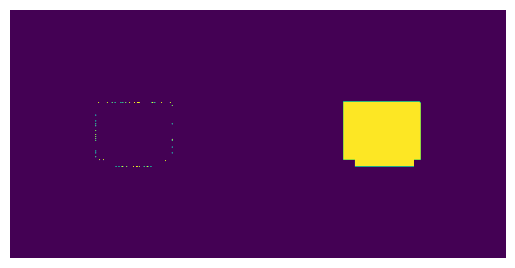

In [29]:
example_data = dataset[0]

plt.figure()
show_datapair(example_data['image'], example_data['label'])
plt.show()

#### Split Dataset into train, validation and test dataset

In [30]:
# Define the sizes for train, validation, and test
train_size = int(0.75 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


### Hyperparamters

In [31]:
batch_size = 16
learning_rate = 1e-5

### Dataloader
Creating a dataloader based on the dataset for batch processing.

TODO: Remove spacing in figure.

torch.Size([16, 1, 256, 256])
torch.Size([1, 256, 256])


/home/daniel/Documents/TUM/ADLR/tum-adlr-02/data/reconstruction_dataset.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


<Figure size 1x19096 with 0 Axes>

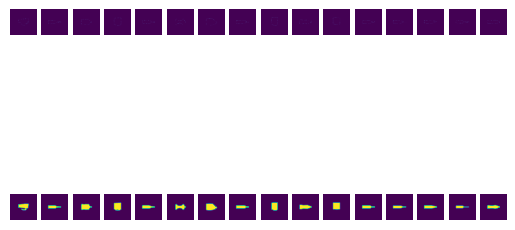

In [32]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)



batch = next(iter(train_loader))
print(batch['image'].shape)

show_datapair_batch(next(iter(train_loader)))


### Initialize Network

In [48]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet1().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Set up TensorBoard
writer = SummaryWriter(f'runs/U-Net_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')

print(device)

cuda


### Training

Epoch [100/50], Step [100/668], Val Loss: 0.7135


<Figure size 640x480 with 0 Axes>

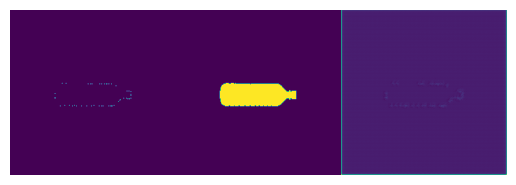

Epoch [200/50], Step [200/668], Val Loss: 0.2833


<Figure size 640x480 with 0 Axes>

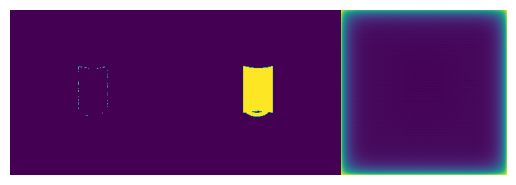

Epoch [300/50], Step [300/668], Val Loss: 0.1230


<Figure size 640x480 with 0 Axes>

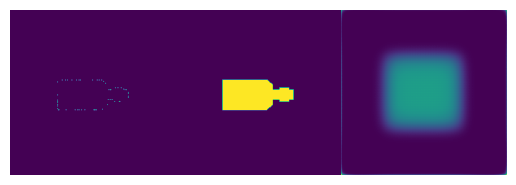

In [ ]:
# Training loop
num_epochs = 50
log_period = 100

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for i, batch in enumerate(train_loader):
        # todo change datatypes in dataset not in dataloader, use proper datatypes, output should be segmentation
        inputs = batch['image'].to(device)#.float()
        labels = batch['label'].to(device)#.float()
        #img_A = img_A.to(device)
        #img_B = img_B.to(device)

        
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        if i % log_period == log_period-1:  # Log every log_period batches

        
            # log training loss
            writer.add_scalar('Loss/train', running_train_loss / log_period, epoch * len(train_loader) + i)
            running_train_loss = 0.0

            # Log reconstructed training images
            img_grid = vutils.make_grid([inputs[-1], labels[-1], outputs[-1]])
            writer.add_image('reconstructed_training_images', img_grid, global_step=epoch * len(train_loader) + i)

            

            
            # calculate validation loss
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    inputs = batch['image'].to(device)
                    labels = batch['label'].to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
        
            val_loss /= len(val_loader)

            # log validation loss
            writer.add_scalar('Loss/val', val_loss, epoch * len(train_loader) + i)


            # Log reconstructed validation images
            img_grid = vutils.make_grid([inputs[-1], labels[-1], outputs[-1]])
            writer.add_image('reconstructed_validation_images', img_grid, global_step=epoch * len(train_loader) + i)

            
            print(f'Epoch [{epoch+1 + i}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Val Loss: {val_loss:.4f}')
            
            model.train()

            
            # ploting images like this until it works with tensorboard
            plt.figure()
            show_datatripple(inputs[-1].cpu().detach().numpy(), labels[-1].cpu().detach().numpy(), outputs[-1].cpu().detach().numpy())
            plt.show()



# Validation step can be added here similarly and log validation loss

writer.close()